In [4]:
import os
import pickle
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt

import nlp_utils
from nlp_utils import Constants as C
import string
import spacy, nltk

import model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ---------------------------------------------------------------------------------------------------------------------------- #
# LOAD DATA
LOAD_DATA = False

if LOAD_DATA:
    df = pd.read_pickle(C.DATA_DIR + C.PS + "dataframe.pkl")
else:
    df_meta = pd.read_csv(C.DATA_DIR + "case_metadata.csv")   
    df_cases = pd.read_pickle("../ps2/" + C.DATA_DIR + "ps2_dataframe.pkl").drop(
        columns=["case_reversed", "judge_id", "year", "log_cites"])
    
    print(str(sorted(set(df_meta["caseid"].values)) == sorted(set(df_cases["caseid"].values))))

    df = pd.concat([df_cases.sort_values(by="caseid").set_index('caseid'),
                        df_meta.sort_values(by="caseid").set_index('caseid')],
                        axis=1, join='inner').reset_index().fillna(0.0)

    df.to_pickle(C.DATA_DIR + C.PS + "dataframe.pkl")

print(df.shape)
df.head(5)

True
(5949, 7)


,caseid,content,case_reversed,judge_id,year,x_republican,log_cites
0,X1037H8N,"BECKER, Circuit Judge.\nThis is a petition fo...",1,114.0,1993.0,1.0,0.000000
1,X10LQ80003,"STRAUB, Circuit Judge.\nDuring his 1997 inaug...",1,2009.0,2002.0,0.0,1.386294
2,X118VF6003,"SEYMOUR, Circuit Judge.\nGerald T. Martin and...",0,1871.0,2004.0,0.0,1.098612
3,X11UUP8003,"EASTERBROOK, Circuit Judge.\nComplaints filed...",1,579.0,2005.0,1.0,3.135494
4,X125RLM003,"LEVAL, Circuit Judge.\nJacob Zedner appeals f...",1,1221.0,2005.0,0.0,2.397895


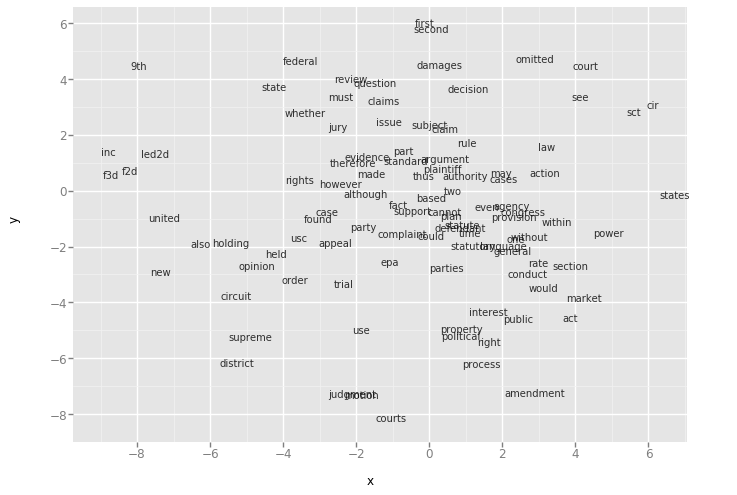

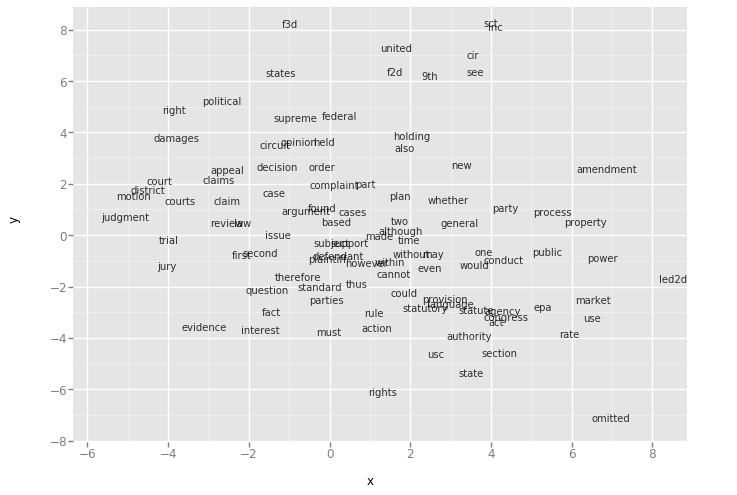

In [2]:
# TASK 1
from gensim.models import Word2Vec
import collections
from sklearn.manifold import TSNE
import ggplot as gg

sentences = []
for doc in df["content"][0:100]: sentences.extend(nlp_utils.get_sentences(doc))

w2v_2 = Word2Vec(sentences,
               workers=8, size=100, min_count=25, window=2, sample=1e-3)

w2v_16 = Word2Vec(sentences,
               workers=8, size=100, min_count=25, window=16, sample=1e-3)

sample_words = [item[0] for item in collections.Counter(
    [token for sentence in sentences for token in sentence]).most_common(200)[:100]]

embeddings_2 = [w2v_2.wv[word] for word in sample_words]
embeddings_16 = [w2v_16.wv[word] for word in sample_words]

wv_tsne_2 = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300).fit_transform(embeddings_2)
wv_tsne_16 = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300).fit_transform(embeddings_16)

df1_2 = pd.DataFrame(sample_words, columns=["word"])
df1_2["x"] = wv_tsne_2[:, 0]
df1_2["y"] = wv_tsne_2[:, 1]

df1_16 = pd.DataFrame(sample_words, columns=["word"])
df1_16["x"] = wv_tsne_16[:, 0]
df1_16["y"] = wv_tsne_16[:, 1]

chart_2 =  gg.ggplot(df1_2, gg.aes(x='x', y='y', label='word')) + gg.geom_text(size=10, alpha=.8, label='word')
chart_2.show()

chart_16 =  gg.ggplot(df1_16, gg.aes(x='x', y='y', label='word')) + gg.geom_text(size=10, alpha=.8, label='word')
chart_16.show()

In [3]:
# TASK 2
from tabulate import tabulate

df_rep = df.loc[df['x_republican'] == 1.0]
df_dem = df.loc[df['x_republican'] == 0.0]

sentences_rep = []
for doc in df_rep["content"][0:500]: sentences_rep.extend(nlp_utils.get_sentences(doc))

sentences_dem = []
for doc in df_dem["content"][0:500]: sentences_dem.extend(nlp_utils.get_sentences(doc))

w2v_rep = Word2Vec(sentences_rep, workers=8, size=200, min_count=25, window=8, sample=1e-3)
w2v_dem = Word2Vec(sentences_dem, workers=8, size=200, min_count=25, window=8, sample=1e-3)

nlp = spacy.load("en", disable=["ner"])
concept = "religion"

N = 10
def list_adjectives(w2v, concept, N=10):
    adj_list = []
    
    similarities = w2v.most_similar(concept, topn=1000)
    
    i = 0
    while len(adj_list) < N:
        pair = similarities[i]
        doc = nlp(pair[0])
        
        if list(doc)[0].pos_ == "ADJ":
            adj_list.append(pair[0])
        
        i = i + 1
    
    return adj_list

related_rep = list_adjectives(w2v_rep, concept, N)
related_dem = list_adjectives(w2v_dem, concept, N)

print(tabulate([[related_rep[i], related_dem[i]] for i in range(N)], headers=["republicans", "democrats"]))

republicans    democrats
-------------  -----------
free           religious
civic          sectarian
regulated      free
temporary      secular
violate        political
domestic       electoral
religious      nonpublic
lawful         private
basic          equal
fide           stos


In [ ]:
# TASK 3
# EFFECT OF TEXT FEATURES ON CITATIONS OR REVERSAL GIVEN FIXED TEXT FEATURES
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.9,
                        max_features=1000, stop_words="english", lowercase=True,
                        use_idf=True, strip_accents="unicode", decode_error="replace", ngram_range=(1, 3))


N = 5948

# Text Features
A = tfidf.fit_transform(df["content"][0:N]).todense()  # Features

# Outcomes
Y = df["log_cites"][0:N].values  # Regression variable

# Confounders
T = df["x_republican"][0:N].copy()
T.loc[df["x_republican"][0:N] == 0.0] = -1  # Binary

print(T.value_counts())
T = T.values
print("A", A.shape, "Y", Y.shape, "T", T.shape)

In [8]:
Model = model.DoubleMLModel(text_features=A, outcomes=Y, confounders=T,
                            model_m_a=RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=-1,
                                                             random_state=42, class_weight="balanced"),
                            model_m_b=RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=-1,
                                                             random_state=42, class_weight="balanced"),
                            model_g_a=RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1,
                                                            random_state=42),
                            model_g_b=RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1,
                                                            random_state=42),
                            frac_a=0.5)

reg_a = LinearRegression(n_jobs=-1, fit_intercept=False)
reg_b = LinearRegression(n_jobs=-1, fit_intercept=False)

# TRAINING ON SAMPLE A, PREDICTION ON B
# Predictions
print("\nTRAINING ON SAMPLE A, PREDICTION ON B")
Y_b_hat_a = Model.train_model_reg(x_train=Model.A_a, y_train=Model.Y_a,
                                  x_test=Model.A_b, y_test=Model.Y_b, model=Model.model_g_a)  # log_cites given text

T_b_hat_a = Model.train_model_cls(x_train=Model.A_a, y_train=Model.T_a,
                                  x_test=Model.A_b, y_test=Model.T_b, model=Model.model_m_a)  # judge party given text

# Residuals
Y_b_tilde_a = Model.Y_b - Y_b_hat_a
T_b_tilde_a = Model.T_b - T_b_hat_a


# TRAINING ON SAMPLE B, PREDICTION ON A
# Predictions
print("\nTRAINING ON SAMPLE B, PREDICTION ON A")
Y_a_hat_b = Model.train_model_reg(x_train=Model.A_b, y_train=Model.Y_b,
                                  x_test=Model.A_a, y_test=Model.Y_a, model=Model.model_g_b)  # log_cites given text

T_a_hat_b = Model.train_model_cls(x_train=Model.A_b, y_train=Model.T_b,
                                  x_test=Model.A_a, y_test=Model.T_a, model=Model.model_m_b)  # judge party given text

# Residuals
Y_a_tilde_b = Model.Y_a - Y_a_hat_b
T_a_tilde_b = Model.T_a - T_a_hat_b

# RESHAPE
T_b_tilde_a = np.reshape(T_b_tilde_a, newshape=(N//2, 1))
T_a_tilde_b = np.reshape(T_a_tilde_b, newshape=(N//2, 1))

# FINAL
reg_a.fit(T_b_tilde_a, Y_b_tilde_a.ravel())
print("theta_a", reg_a.coef_)

reg_b.fit(T_a_tilde_b, Y_a_tilde_b.ravel())
print("theta_b", reg_b.coef_)


scores = [
    ["MSE",
     mean_squared_error(Y_b_tilde_a, reg_a.predict(T_b_tilde_a)),
     mean_squared_error(Y_a_tilde_b, reg_b.predict(T_a_tilde_b))]
]

print(tabulate(scores, headers=["theta_a", "theta_b"]))

theta = (reg_a.coef_ + reg_b.coef_)/2
print("if theta >> 0 then republican judges get more cites, if theta << 0, then democrat judges get more cites")
print("if theta is apppr. 0, then judge partisanship makes no contribution")
print("theta_a", reg_a.coef_)
print("theta_b", reg_b.coef_)
print("theta\t", theta)


TRAINING ON SAMPLE A, PREDICTION ON B
metric      y_train_hat    y_test_hat
--------  -------------  ------------
MSE            0.960654       1.00942
metric      y_train_hat    y_test_hat
--------  -------------  ------------
Accuracy       0.649294      0.541695
F1             0.669204      0.580486

TRAINING ON SAMPLE B, PREDICTION ON A
metric      y_train_hat    y_test_hat
--------  -------------  ------------
MSE            0.949561      0.992709
metric      y_train_hat    y_test_hat
--------  -------------  ------------
Accuracy       0.662071      0.578346
F1             0.666224      0.581442
theta_a [-0.0067364]
theta_b [-0.0192598]
       theta_a    theta_b
---  ---------  ---------
MSE    1.00933   0.992083
if theta >> 0 then republican judges get more cites, if theta << 0, then democrat judges get more cites
if theta is apppr. 0, then judge partisanship makes no contribution
theta_a [-0.0067364]
theta_b [-0.0192598]
theta	 [-0.0129981]
